SETUP

In [1]:
!pip -q install transformers sentence-transformers emoji google-api-python-client

import re, numpy as np, pandas as pd
np.random.seed(42)

CONF_THRESHOLDS = [0.6, 0.8]
MIN_WORD_FILTERS = [3, 5, 7]

TEXT_COL = "comment_text"
EMOJI_COL = "emojis"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 10.3 MB/s eta 0:00:00


LOAD DATASET

In [6]:
df = pd.read_csv("youtube_comments_raw.csv")
print(df.shape)
df.head()


(1000, 5)


,comment_id,comment_text,like_count,reply_count,emojis
0,UgzQTQItIuuekgx_vuJ4AaABAg,🖤,0,0,🖤
1,UgwPZhPDRfmwjMlUI4B4AaABAg,Bu mahnini dinledikce Atamin ayriligi gözûmûn ...,0,0,😢😢😢😢😢😢🥀🥀🥀🥀🥀💔💔💔
2,UgyOoG5vI3Z19PLZxJd4AaABAg,Çox gözəl əsərdir. Necə gözəl istedad özü- özü...,0,0,NaN
3,UgxaxJgFiFSnap4tNEZ4AaABAg,🥀,0,0,🥀
4,UgwIs5CZV0ctHredytp4AaABAg,Cane can,0,0,NaN


REMOVE URLS, NORMALIZE SPACING, REDUCE NOISE

In [7]:
url_re = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)

def normalize_text_az(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = url_re.sub("", text)
    text = text.replace("\n", " ").replace("\t", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_no_url"] = df["comment_text"].astype(str).map(normalize_text_az)


REMOVE EMOJIS FROM TEXT TO CREATE CLEAN TEXT CHANNEL

In [8]:
import emoji
def remove_emojis(text: str) -> str:
    return emoji.replace_emoji(text, replace="") if isinstance(text, str) else ""

df["text_no_emoji"] = df["text_no_url"].map(remove_emojis).str.strip()


PARAMETER BASED EXPERIMENTS. MODEL LOCALDOC, 3-CLASS (https://huggingface.co/LocalDoc/sentiment_analysis_azerbaijani)


SENTIMENT MODEL

In [9]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

LD_MODEL = "LocalDoc/sentiment_analysis_azerbaijani"
tok_ld = AutoTokenizer.from_pretrained(LD_MODEL)
mdl_ld = AutoModelForSequenceClassification.from_pretrained(LD_MODEL)
mdl_ld.eval()

LABELS = np.array(["negative","neutral","positive"])

def run_localdoc(texts: pd.Series, batch_size=16, max_length=128) -> np.ndarray:
    texts = texts.fillna("").astype(str)
    out = []
    for i in range(0, len(texts), batch_size):
        batch = texts.iloc[i:i+batch_size].tolist()
        enc = tok_ld(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        with torch.no_grad():
            probs = F.softmax(mdl_ld(**enc).logits, dim=-1)
        out.append(probs.cpu().numpy())
    return np.vstack(out)

probs = run_localdoc(df["text_no_emoji"])
df["ld_neg"], df["ld_neu"], df["ld_pos"] = probs[:,0], probs[:,1], probs[:,2]

def apply_threshold_3class(df, neg, neu, pos, T):
    P = df[[neg, neu, pos]].values
    idx = P.argmax(axis=1)
    conf = P.max(axis=1)
    pred = LABELS[idx].astype(object)
    pred[conf < T] = "neutral"
    return pred, conf

df["ld_label_06"], df["ld_conf"] = apply_threshold_3class(df,"ld_neg","ld_neu","ld_pos",0.6)
df["ld_label_08"], _            = apply_threshold_3class(df,"ld_neg","ld_neu","ld_pos",0.8)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/924 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

DISTRIBUTIONS REPORT FOR THRESHOLDS 0.6 AND 0.8

In [10]:
def dist(col):
    return df[col].value_counts().reindex(["positive","negative","neutral"], fill_value=0)

summary_thresh = pd.DataFrame({
    "LocalDoc_0.6": dist("ld_label_06"),
    "LocalDoc_0.8": dist("ld_label_08"),
})
summary_thresh["delta_(0.8-0.6)"] = summary_thresh["LocalDoc_0.8"] - summary_thresh["LocalDoc_0.6"]
summary_thresh


,LocalDoc_0.6,LocalDoc_0.8,delta_(0.8-0.6)
positive,432,418,-14
negative,211,208,-3
neutral,357,374,17


COMMENT LENGTH FILTERING (>= 3, >= 5, >= 7 WORDS)

In [11]:
df["word_count"] = df["text_no_emoji"].fillna("").str.split().str.len()

rows = []

for w in [3, 5, 7]:
    sub = df[df["word_count"] >= w]

    for T, label_col in [(0.6, "ld_label_06"), (0.8, "ld_label_08")]:
        rows.append({
            "min_words": w,
            "threshold": T,
            "num_comments": len(sub),
            "positive": int(sub[label_col].eq("positive").sum()),
            "negative": int(sub[label_col].eq("negative").sum()),
            "neutral":  int(sub[label_col].eq("neutral").sum()),
        })

length_threshold_table = pd.DataFrame(rows)
length_threshold_table



,min_words,threshold,num_comments,positive,negative,neutral
0,3,0.6,781,377,204,200
1,3,0.8,781,363,202,216
2,5,0.6,624,326,164,134
3,5,0.8,624,314,164,146
4,7,0.6,491,263,134,94
5,7,0.8,491,255,134,102


In [12]:
pivot = length_threshold_table.pivot_table(
    index=["min_words", "threshold"],
    values=["positive", "negative", "neutral"],
    aggfunc="sum"
)
pivot


negative  neutral  positive
min_words threshold                             
3         0.6             204      200       377
          0.8             202      216       363
5         0.6             164      134       326
          0.8             164      146       314
7         0.6             134       94       263
          0.8             134      102       255

ANALYTICAL TASKS

EMOJI-TEXT INCONSISTENCY

EMOJI-ONLY SENTIMENT LABELING (3-CLASS)

In [13]:
EMOJI_SENT_MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tok_em = AutoTokenizer.from_pretrained(EMOJI_SENT_MODEL)
mdl_em = AutoModelForSequenceClassification.from_pretrained(EMOJI_SENT_MODEL)
mdl_em.eval()

def emoji_to_words(s: str) -> str:
    # convert emojis like ❤️😭 -> "red_heart crying_face"
    if not isinstance(s, str): return ""
    return " ".join(emoji.demojize(ch).strip(":").replace("-", "_") for ch in s if ch in emoji.EMOJI_DATA)

df["emoji_text"] = df["emojis"].astype(str).map(emoji_to_words).str.replace(r"\s+", " ", regex=True).str.strip()

def run_emoji_sent(texts: pd.Series, batch_size=32, max_length=64) -> np.ndarray:
    texts = texts.fillna("").astype(str)
    out=[]
    for i in range(0,len(texts),batch_size):
        batch=texts.iloc[i:i+batch_size].tolist()
        enc=tok_em(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        with torch.no_grad():
            probs=F.softmax(mdl_em(**enc).logits, dim=-1)
        out.append(probs.cpu().numpy())
    return np.vstack(out)

emoji_rows = df[df["emoji_text"].str.strip().ne("")].copy()
ep = run_emoji_sent(emoji_rows["emoji_text"])
emoji_rows["emoji_neg"], emoji_rows["emoji_neu"], emoji_rows["emoji_pos"] = ep[:,0], ep[:,1], ep[:,2]
emoji_rows["emoji_label_06"], emoji_rows["emoji_conf"] = apply_threshold_3class(emoji_rows,"emoji_neg","emoji_neu","emoji_pos",0.6)

df = df.merge(
    emoji_rows[["comment_id","emoji_neg","emoji_neu","emoji_pos","emoji_label_06","emoji_conf"]],
    on="comment_id",
    how="left"
)


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

COMPUTE INCONSISTENCIES

In [14]:
df_both = df[df["emoji_label_06"].notna() & df["ld_label_06"].notna()].copy()
inconsistent = df_both[df_both["emoji_label_06"] != df_both["ld_label_06"]]

len(inconsistent), len(df_both)


(207, 357)

In [15]:
inconsistent.sample(10, random_state=42)[["text_no_emoji","emoji_text","ld_label_06","emoji_label_06"]]


,text_no_emoji,emoji_text,ld_label_06,emoji_label_06
738,Ayrılığın olub agah,black_heart,negative,neutral
81,Bu yaşa qədər bildiyim 4səhvin 1düzü apardığı ...,expressionless_face pensive_face,neutral,negative
374,Eziz nenem ve babam kaş bu son görüş olmayaydi...,crying_face crying_face crying_face,positive,negative
501,"Ən pisi də o görüşün son görüş,son vida olacağ...",wilted_flower downcast_face_with_sweat broken_...,neutral,negative
772,mohtesem yazmisiz masallah Elza Seyidcahan,red_heart folded_hands thumbs_up flexed_biceps...,positive,neutral
57,Xalxın uşağı,red_heart,positive,neutral
520,Tik-tok mik tok bilmirem men. 30 yashim var. E...,clapping_hands clapping_hands clapping_hands,positive,neutral
658,"Bu elə bir mahıdır ki, 7 il sonra koment bildi...",smiling_face_with_tear,positive,neutral
94,Cox sevirem bu muzik,crying_face,positive,negative
697,kaş Spotify və ya apple music də əlavə olunsa ...,confused_face,neutral,negative


SEMANTICALLY SIMILAR COMMENTS

In [16]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

embedder = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
emb = embedder.encode(df["text_no_emoji"].fillna("").tolist(), batch_size=32, show_progress_bar=True)

sim = cosine_similarity(emb)
np.fill_diagonal(sim, 0)

SIM_THRESHOLD = 0.90
pairs = np.argwhere(sim > SIM_THRESHOLD)
pairs = [(i,j,sim[i,j]) for i,j in pairs if i < j]

len(pairs)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2776

In [27]:
shown = 0
for i, j, s in pairs:
    a = str(df.iloc[i]["text_no_emoji"]).strip()
    b = str(df.iloc[j]["text_no_emoji"]).strip()
    if not a or not b:
        continue
    print(f"sim={s:.3f}")
    print("A:", a)
    print("B:", b)
    print("-"*60)
    shown += 1
    if shown >= 8:
        break



sim=0.965
A: 3:37
B: 3:52
------------------------------------------------------------
sim=0.911
A: Sağ ol
B: Çox gözəl sağ olun.Elza xanım
------------------------------------------------------------
sim=0.913
A: 2026 dinləyən var?
B: 2025 dinləyənnn?
------------------------------------------------------------
sim=0.950
A: 2026 dinləyən var?
B: 2035 də dinləyənlər?
------------------------------------------------------------
sim=0.907
A: 2026 dinləyən var?
B: 2025 dinləyən var???
------------------------------------------------------------
sim=0.955
A: 2026 dinləyən var?
B: 2025 də dinləyən var?
------------------------------------------------------------
sim=0.971
A: 2026 dinləyən var?
B: 2026 hələ dinləyən var?
------------------------------------------------------------
sim=0.932
A: 2026 +
B: 2025
------------------------------------------------------------


SEMANTIC OUTLIERS

In [28]:
avg_sim = sim.mean(axis=1)
df["avg_semantic_similarity"] = avg_sim

thr = np.percentile(avg_sim, 5)   # bottom 5%
outliers = df[df["avg_semantic_similarity"] < thr]
len(outliers)


48

In [29]:
outliers.sample(8, random_state=42)[["text_no_emoji","avg_semantic_similarity"]]


,text_no_emoji,avg_semantic_similarity
446,2025-e gediriy yeginki azalar 2025-de qulaq as...,0.130037
886,Bu mahni meni her zaman uzaqlara aparan mahnla...,0.184639
441,2025-E son 30 gün amma helede yoxdu,0.206471
931,Мурашки по коже,0.203482
382,2025in ilk günü ilk qulaq asdığım,0.199530
615,ela bu xanimin sesi cox gozeldi.Oxudugu bestel...,0.210266
230,2025,0.210609
336,2025 kimlər var?,0.164951


POPULAR COMMENT ANALYSIS

In [30]:
like_thr  = df["like_count"].quantile(0.9)
reply_thr = df["reply_count"].quantile(0.9)

popular = df[(df["like_count"] >= like_thr) | (df["reply_count"] >= reply_thr)].copy()
len(popular)


1000

In [31]:
from collections import Counter
from nltk import ngrams

def tok_words(t):
    return [w for w in str(t).lower().split() if len(w) > 2]

wc = Counter()
bg = Counter()

for t in popular["text_no_emoji"].fillna(""):
    w = tok_words(t)
    wc.update(w)
    bg.update(ngrams(w, 2))

wc.most_common(20), bg.most_common(10)


([('son', 248),
  ('elza', 177),
  ('çox', 127),
  ('bir', 127),
  ('amma', 56),
  ('gözəl', 53),
  ('görüş', 50),
  ('vida,', 49),
  ('qulaq', 48),
  ('var', 46),
  ('kaş', 45),
  ('bele', 45),
  ('belə', 44),
  ('mahnı', 43),
  ('xanım', 40),
  ('cox', 40),
  ('hər', 39),
  ('səni', 39),
  ('kimi', 35),
  ('qədər', 32)],
 [(('son', 'vida,'), 49),
  (('vida,', 'son'), 49),
  (('elza', 'xanım'), 33),
  (('son', 'görüş'), 25),
  (('elza', 'xanim'), 23),
  (('son', 'vida'), 22),
  (('son', 'görüş.'), 20),
  (('kaş', 'görüş'), 18),
  (('elza', 'xanımın'), 18),
  (('çox', 'gözəl'), 17)])

SEMANTIC CATEGORY-BASED SENTIMENT ANALYSIS (5 CATEGORIES)

ZERO-SHOT SEMANTIC CATEGORY CLASSIFIER

In [32]:
from transformers import pipeline

zsc = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")

CATS = [
    "Rational positive feedback on content",
    "Emotional reaction",
    "Criticism and dissatisfaction",
    "Direct address to the author",
    "Troll / non-constructive comment"
]

def classify_category(text):
    text = str(text).strip()
    if not text:
        return "Troll / non-constructive comment"
    out = zsc(text, CATS, multi_label=False)
    return out["labels"][0]

df["semantic_category"] = df["text_no_emoji"].apply(classify_category)
df["semantic_category"].value_counts()


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


,count
semantic_category,
Rational positive feedback on content,323
Emotional reaction,270
Troll / non-constructive comment,263
Criticism and dissatisfaction,113
Direct address to the author,31


SENTIMENTS COUNT PER CATEGORY

In [33]:
table = pd.crosstab(df["semantic_category"], df["ld_label_06"])
table = table.reindex(CATS).fillna(0).astype(int)
table


ld_label_06,negative,neutral,positive
semantic_category,,,
Rational positive feedback on content,38,88,197
Emotional reaction,63,59,148
Criticism and dissatisfaction,48,38,27
Direct address to the author,7,13,11
Troll / non-constructive comment,55,159,49


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

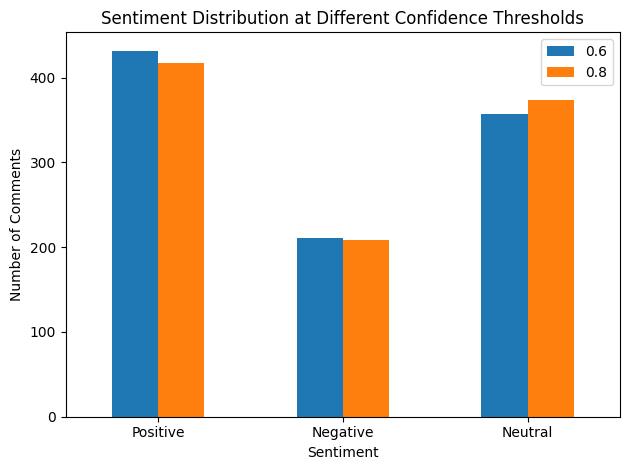

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Sentiment": ["Positive", "Negative", "Neutral"],
    "0.6": [
        (df["ld_label_06"]=="positive").sum(),
        (df["ld_label_06"]=="negative").sum(),
        (df["ld_label_06"]=="neutral").sum(),
    ],
    "0.8": [
        (df["ld_label_08"]=="positive").sum(),
        (df["ld_label_08"]=="negative").sum(),
        (df["ld_label_08"]=="neutral").sum(),
    ]
}

plot_df = pd.DataFrame(data).set_index("Sentiment")
plot_df.plot(kind="bar")
plt.title("Sentiment Distribution at Different Confidence Thresholds")
plt.ylabel("Number of Comments")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


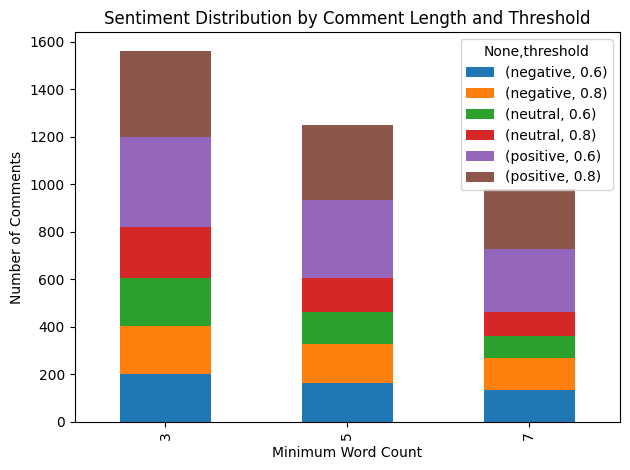

In [38]:
plot_df = length_threshold_table.pivot_table(
    index="min_words",
    columns="threshold",
    values=["positive", "negative", "neutral"],
    aggfunc="sum"
)

plot_df.plot(kind="bar", stacked=True)
plt.title("Sentiment Distribution by Comment Length and Threshold")
plt.ylabel("Number of Comments")
plt.xlabel("Minimum Word Count")
plt.tight_layout()
plt.show()



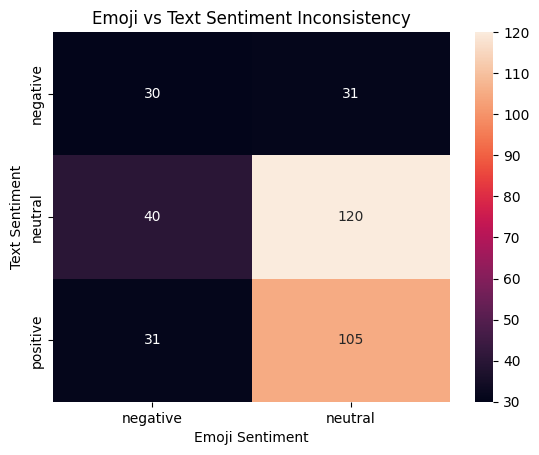

In [40]:
import seaborn as sns

cm = pd.crosstab(df["ld_label_06"], df["emoji_label_06"])

sns.heatmap(cm, annot=True, fmt="d")
plt.title("Emoji vs Text Sentiment Inconsistency")
plt.xlabel("Emoji Sentiment")
plt.ylabel("Text Sentiment")
plt.show()


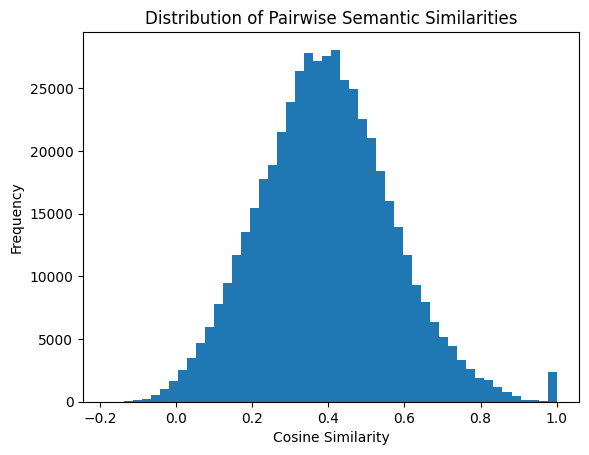

In [41]:
upper = sim[np.triu_indices_from(sim, k=1)]

plt.hist(upper, bins=50)
plt.title("Distribution of Pairwise Semantic Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


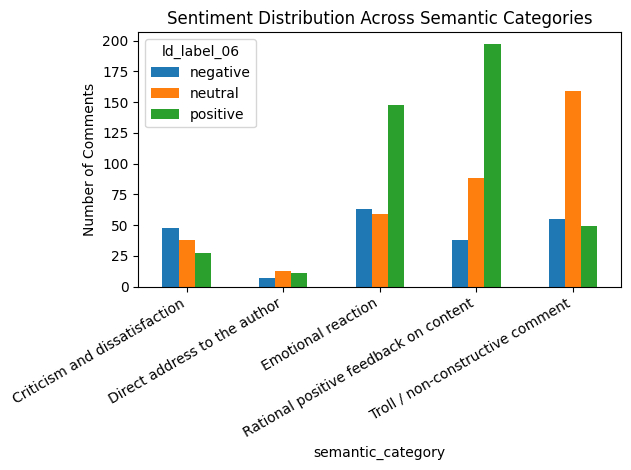

In [42]:
cat_sent = pd.crosstab(df["semantic_category"], df["ld_label_06"])

cat_sent.plot(kind="bar")
plt.title("Sentiment Distribution Across Semantic Categories")
plt.ylabel("Number of Comments")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
